# Do all analysis and plots

In [1]:
import os

import numpy as np
import matplotlib.pyplot as pl
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import pandas as pd
from scipy.optimize import curve_fit
import statsmodels.api as sm
import statsmodels.formula.api as smf
import xarray as xr

In [2]:
os.makedirs('../plots', exist_ok=True)

In [3]:
pl.style.use('../defaults.mplstyle')

In [4]:
# no CH4 removal, i.e. fair default runs, with no temperature rebasing
noch4r = xr.open_dataset('../results/noCH4R_cal-1.4.0.nc')

In [5]:
# CH4 removal runs with temperature rebasing
ch4r = xr.open_dataset('../results/CH4R_cal-1.4.0.nc')

In [6]:
# CH4 lifetime in the default case
noch4r_lifetime = xr.open_dataset('../results/noCH4R_lifetime_cal-1.4.0.nc')

In [7]:
config0 = noch4r_lifetime.config[0].values[()]

## These are raw outputs for the first ssp119 ensemble member in 2010 and should not differ.

In [8]:
noch4r.temperature.sel(timebound=2010, scenario='ssp119', config=config0, layer=0).data[()]

0.9056394077333171

In [9]:
ch4r.temperature.sel(timebound=2010, scenario='ssp119', config=config0).data[()]

0.9056394077333171

In [10]:
temp_norm_20032022 = np.ones(21)
temp_norm_20032022[0] = 0.5
temp_norm_20032022[-1] = 0.5

In [11]:
np.average(noch4r.temperature.sel(timebound=np.arange(2003, 2024), scenario='ssp119', config=config0, layer=0), weights=temp_norm_20032022)

1.0176562361397754

In [12]:
np.average(ch4r.temperature.sel(timebound=np.arange(2003, 2024), scenario='ssp119', config=config0), weights=temp_norm_20032022)

1.0176562361397754

## ssp119 peak warming

Using the 1.03C present-day warming convention

In [13]:
(
    noch4r.temperature.loc[
        dict(scenario='ssp119', layer=0)
    ] - np.average(
        noch4r.temperature.loc[
            dict(scenario='ssp119', layer=0, timebound=np.arange(2003,2024))
        ], axis=0, weights=temp_norm_20032022
    ) + 1.03
).median(dim='config').max()

<xarray.DataArray 'temperature' ()>
array(1.55715509)
Coordinates:
    scenario  <U6 'ssp119'
    layer     int32 0

In [14]:
(
    noch4r.temperature.loc[
        dict(scenario='COFFEE1.1 EN_NPi2020_400f_lowBECCS', layer=0)
    ] - np.average(
        noch4r.temperature.loc[
            dict(scenario='COFFEE1.1 EN_NPi2020_400f_lowBECCS', layer=0, timebound=np.arange(2003,2024))
        ], axis=0, weights=temp_norm_20032022
    ) + 1.03
).median(dim='config').max()

<xarray.DataArray 'temperature' ()>
array(1.76620171)
Coordinates:
    scenario  <U34 'COFFEE1.1 EN_NPi2020_400f_lowBECCS'
    layer     int32 0

## Main analysis

In [15]:
ecs_tcr = pd.read_csv('../results/ecs_tcr_cal-1.4.0.csv', index_col=0)

In [16]:
colors = {
    'ssp119': '#00a9cf',
    'COFFEE1.1 EN_NPi2020_400f_lowBECCS': '#707070', #'#B8BDAA',
    'ssp534-over': '#92397a'
}

In [17]:
scenarios = ['ssp119', 'COFFEE1.1 EN_NPi2020_400f_lowBECCS', 'ssp534-over']
labels = {
    'ssp119': 'SSP1-1.9',
    'COFFEE1.1 EN_NPi2020_400f_lowBECCS': 'IMP-Neg',
    'ssp534-over': 'SSP5-3.4-overshoot'
}

In [18]:
def powerfit(x, a, b, c):
    return a + b * x**c

def squarerootfit(x, b):
    return 1.5 + b * x**0.5

def squarefit(x, b):
    return b * (x-1.5)**2

In [19]:
quantiles = [.05, .25, .50, .75, .95]
mod = {}
res_all = {}
x_p = {}
df_p = {}
p = {}
cov = {}
exceeds = {}

modsr = {}
res_allsr = {}
x_psr = {}
df_psr = {}
psr = {}
covsr = {}

modsq = {}
res_allsq = {}
x_psq = {}
df_psq = {}
psq = {}
covsq = {}

for iscen, scenario in enumerate(scenarios):
    over1p5 = (
        np.max(
            noch4r.temperature.loc[
                dict(scenario=scenario, layer=0)
            ] - np.average(
                noch4r.temperature.loc[
                    dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        )
    ) >= 1.5
    x = (
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        ).data[over1p5]/1000
    )
    y = (
        np.max(
            noch4r.temperature.loc[
                dict(scenario=scenario, layer=0)
            ] - np.average(
                noch4r.temperature.loc[
                    dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        ).data[over1p5]
    )
    exceeds[scenario] = (
        np.max(
            ch4r.temperature.loc[
                dict(scenario=scenario)
            ] - np.average(
                ch4r.temperature.loc[
                    dict(scenario=scenario, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        ).data > 1.5
    )
    xe = (
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        ).data[over1p5 & ~exceeds[scenario]]/1000
    )
    ye = (
        np.max(
            noch4r.temperature.loc[
                dict(scenario=scenario, layer=0)
            ] - np.average(
                noch4r.temperature.loc[
                    dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        ).data[over1p5 & ~exceeds[scenario]]
    )
    
    d = {'peak': ye, 'ch4': xe}
    dsr = {'peak': ye, 'ch4': xe}
    df = pd.DataFrame(data=d)
    
    # scipy curve_fit
    p[scenario], cov[scenario] = curve_fit(powerfit, xe, ye, maxfev=5000)
    psr[scenario], covsr[scenario] = curve_fit(squarerootfit, xe, ye)
    psq[scenario], covsq[scenario] = curve_fit(squarefit, ye, xe)
    
    # use the best estimate of the exponent from this to feed into the quantile regression
    
    # statsmodels fit
    mod[scenario] = smf.quantreg(f'peak ~  I(ch4 ** {p[scenario][2]})', df)
    modsr[scenario] = smf.quantreg(f'peak ~ I(ch4 ** 0.5)', df)
    modsq[scenario] = smf.quantreg(f'ch4 ~ I(peak ** 2)', df)
    
    # get all result instances in a list
    res_all[scenario] = [mod[scenario].fit(q=q) for q in quantiles]
    x_p[scenario] = np.linspace(0, x.max(), 100)
    df_p[scenario] = pd.DataFrame({'ch4': x_p})

    res_allsr[scenario] = [modsr[scenario].fit(q=q) for q in quantiles]
    x_psr[scenario] = np.linspace(0, x.max(), 100)
    df_psr[scenario] = pd.DataFrame({'ch4': x_psr})

    res_allsq[scenario] = [modsq[scenario].fit(q=q) for q in quantiles]
    x_psq[scenario] = np.linspace(0, y.max(), 100)
    df_psq[scenario] = pd.DataFrame({'peak': x_psq})

In [20]:
psq

{'ssp119': array([91.34894187]),
 'COFFEE1.1 EN_NPi2020_400f_lowBECCS': array([72.89993079]),
 'ssp534-over': array([67.67052135])}

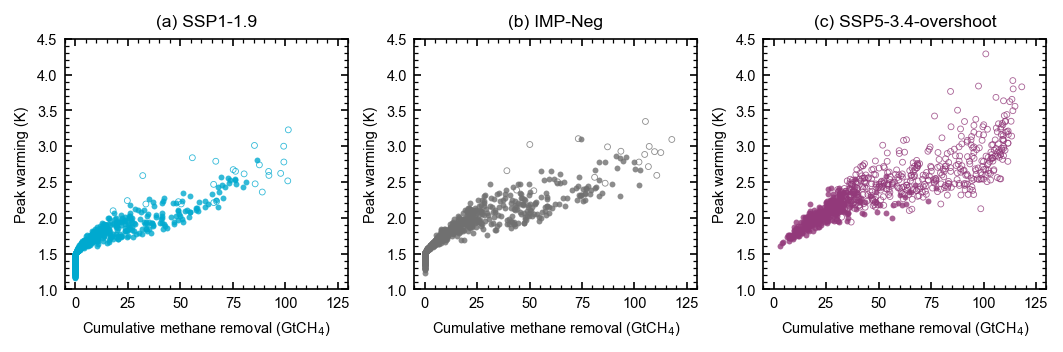

In [21]:
fig, ax = pl.subplots(1, 3, figsize=(18/2.54, 6/2.54))
for iscen, scenario in enumerate(scenarios):
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[~exceeds[scenario]]/1000, 
        np.max(
            noch4r.temperature.loc[
                dict(scenario=scenario, layer=0)
            ] - np.average(
                noch4r.temperature.loc[
                    dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        )[~exceeds[scenario]],
        label=labels[scenario],
        s=8,
        lw=0,
        alpha=0.8,
        color=colors[scenario],
        marker="o"
    )
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[exceeds[scenario]]/1000, 
        np.max(
            noch4r.temperature.loc[
                dict(scenario=scenario, layer=0)
            ] - np.average(
                noch4r.temperature.loc[
                    dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        )[exceeds[scenario]],
        label=labels[scenario],
        s=8,
        lw=0.4,
        alpha=0.8,
        edgecolor=colors[scenario],
        color="None",
        marker="o"
    )
#     for qm, res in zip(quantiles, res_all[scenario]):
#         q[qm] = res.predict({'peak': x_p[scenario]})
        # get prediction for the model and plot
        # here we use a dict which works the same way as the df in ols
#     ax[iscen].fill_between(x_p[scenario], q[.05], q[.95], color='k', alpha=0.3, lw=0)
#     ax[iscen].plot(x_p[scenario], q[.5], color='k')

    ax[iscen].set_title(f'({chr(97+iscen)}) {labels[scenario]}')
    ax[iscen].set_xlabel('Cumulative methane removal (GtCH$_4$)')
    ax[iscen].set_ylabel('Peak warming (K)')
    ax[iscen].set_xlim(-5, 130)
    ax[iscen].set_ylim(1, 4.5)
fig.tight_layout()
pl.savefig('../plots/cumCH4_peakT_cal-1.4.0.png')
pl.savefig('../plots/cumCH4_peakT_cal-1.4.0.pdf')

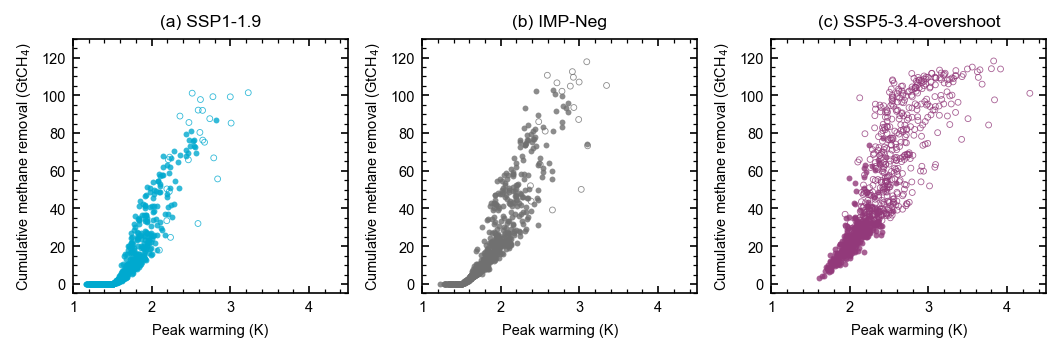

In [22]:
fig, ax = pl.subplots(1, 3, figsize=(18/2.54, 6/2.54))
for iscen, scenario in enumerate(scenarios):
    ax[iscen].scatter(
        np.max(
            noch4r.temperature.loc[
                dict(scenario=scenario, layer=0)
            ] - np.average(
                noch4r.temperature.loc[
                    dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        )[~exceeds[scenario]],
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[~exceeds[scenario]]/1000, 
        label=labels[scenario],
        s=8,
        lw=0,
        alpha=0.8,
        color=colors[scenario],
        marker="o"
    )
    ax[iscen].scatter(
        np.max(
            noch4r.temperature.loc[
                dict(scenario=scenario, layer=0)
            ] - np.average(
                noch4r.temperature.loc[
                    dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        )[exceeds[scenario]],
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[exceeds[scenario]]/1000, 
        label=labels[scenario],
        s=8,
        lw=0.4,
        alpha=0.8,
        edgecolor=colors[scenario],
        color="None",
        marker="o"
    )
#     for qm, res in zip(quantiles, res_all[scenario]):
#         q[qm] = res.predict({'peak': x_p[scenario]})
        # get prediction for the model and plot
        # here we use a dict which works the same way as the df in ols
#     ax[iscen].fill_between(x_p[scenario], q[.05], q[.95], color='k', alpha=0.3, lw=0)
#     ax[iscen].plot(x_p[scenario], q[.5], color='k')

    ax[iscen].set_title(f'({chr(97+iscen)}) {labels[scenario]}')
    ax[iscen].set_ylabel('Cumulative methane removal (GtCH$_4$)')
    ax[iscen].set_xlabel('Peak warming (K)')
    ax[iscen].set_ylim(-5, 130)
    ax[iscen].set_xlim(1, 4.5)
fig.tight_layout()
pl.savefig('../plots/peakT_cumCH4_cal-1.4.0.png')
pl.savefig('../plots/peakT_cumCH4_cal-1.4.0.pdf')

## gigatons removal required in ssp119 to avoid peak 1.5C

In [23]:
for scenario in scenarios:
    print(scenario, 
        np.percentile(-np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[~exceeds[scenario]]/1000, (5, 50, 95, 100))
    )

ssp119 [-0.    1.15 48.13 86.68]
COFFEE1.1 EN_NPi2020_400f_lowBECCS [  0.      9.32   66.596 102.68 ]
ssp534-over [ 9.5  23.48 46.02 77.12]


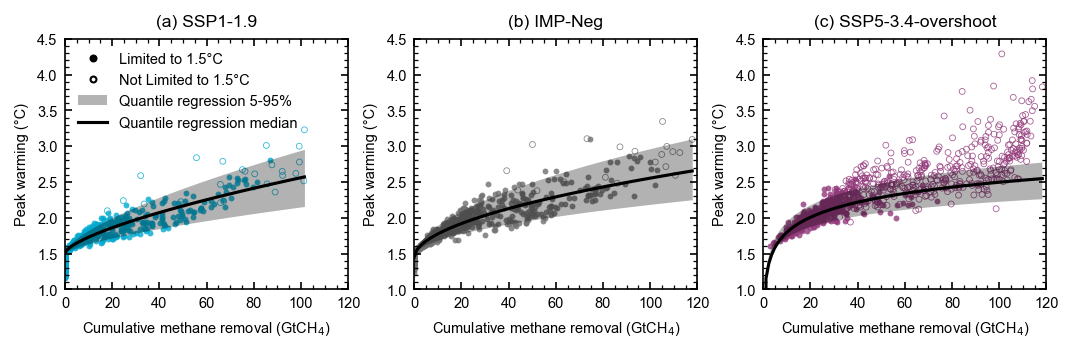

In [24]:
fig, ax = pl.subplots(1, 3, figsize=(18/2.54, 6/2.54))
for iscen, scenario in enumerate(scenarios):
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[~exceeds[scenario]]/1000, 
        np.max(
            noch4r.temperature.loc[
                dict(scenario=scenario, layer=0)
            ] - np.average(
                noch4r.temperature.loc[
                    dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        )[~exceeds[scenario]],
        label=labels[scenario],
        s=8,
        lw=0,
        alpha=0.8,
        color=colors[scenario],
        marker="o"
    )
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[exceeds[scenario]]/1000, 
        np.max(
            noch4r.temperature.loc[
                dict(scenario=scenario, layer=0)
            ] - np.average(
                noch4r.temperature.loc[
                    dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        )[exceeds[scenario]],
        label=labels[scenario],
        s=8,
        lw=0.4,
        alpha=0.8,
        edgecolor=colors[scenario],
        color="None",
        marker="o"
    )
    
    q = {}
    for qm, res in zip(quantiles, res_all[scenario]):
        q[qm] = res.predict({'ch4': x_p[scenario]})
        # get prediction for the model and plot
        # here we use a dict which works the same way as the df in ols
    #ax[iscen].fill_between(x_p[scenario], q[.05], q[.95], color='k', alpha=0.3, lw=0)
    #ax[iscen].plot(x_p[scenario], q[.5], color='k')
    ax[iscen].fill_between(x_p[scenario], q[.05], q[.95], color='k', alpha=0.3, lw=0)
    ax[iscen].plot(x_p[scenario], q[.5], color='k')

    ax[iscen].set_title(f'({chr(97+iscen)}) {labels[scenario]}')
    ax[iscen].set_xlabel('Cumulative methane removal (GtCH$_4$)')
    ax[iscen].set_ylabel('Peak warming (°C)')
    ax[iscen].set_xlim(0, 120)
    ax[iscen].set_ylim(1, 4.5)
    

# Custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color="None", label='Limited to 1.5°C', markerfacecolor='k', markersize=np.sqrt(8)),
    Line2D([0], [0], marker='o', color='None', label='Not Limited to 1.5°C', markerfacecolor='w', markeredgecolor='k', markersize=np.sqrt(8), lw=0.4),
    Patch(facecolor='0.7', lw=0, label='Quantile regression 5-95%'),
    Line2D([0], [0], color='k', lw=1.5, label='Quantile regression median'),
]
ax[0].legend(handles=legend_elements, loc='upper left', frameon=False)

fig.tight_layout()
pl.savefig('../plots/cumCH4_peakT_quant_cal-1.4.0.png')
pl.savefig('../plots/cumCH4_peakT_quant_cal-1-4-0.pdf')

In [25]:
for scenario in scenarios:
    for qidx in [0, 2, 4]:
        print(scenario, quantiles[qidx])
        print(res_all[scenario][qidx].params)
        print()

ssp119 0.05
Intercept                      1.500701
I(ch4 ** 0.681129740820461)    0.028258
dtype: float64

ssp119 0.5
Intercept                      1.510007
I(ch4 ** 0.681129740820461)    0.045621
dtype: float64

ssp119 0.95
Intercept                      1.531263
I(ch4 ** 0.681129740820461)    0.061283
dtype: float64

COFFEE1.1 EN_NPi2020_400f_lowBECCS 0.05
Intercept                       1.475946
I(ch4 ** 0.5288097380210467)    0.062315
dtype: float64

COFFEE1.1 EN_NPi2020_400f_lowBECCS 0.5
Intercept                       1.44552
I(ch4 ** 0.5288097380210467)    0.09702
dtype: float64

COFFEE1.1 EN_NPi2020_400f_lowBECCS 0.95
Intercept                       1.445270
I(ch4 ** 0.5288097380210467)    0.133112
dtype: float64

ssp534-over 0.05
Intercept                         -123.726336
I(ch4 ** 0.0017408356437590138)    124.943072
dtype: float64

ssp534-over 0.5
Intercept                         -172.576879
I(ch4 ** 0.0017408356437590138)    173.674937
dtype: float64

ssp534-over 0.95


In [26]:
for scenario in scenarios:
    for qidx in [0, 2, 4]:
        print(scenario, quantiles[qidx])
        print(res_allsq[scenario][qidx].params)
        print()

ssp119 0.05
Intercept      -24.737608
I(peak ** 2)    10.263231
dtype: float64

ssp119 0.5
Intercept      -43.169136
I(peak ** 2)    18.165212
dtype: float64

ssp119 0.95
Intercept      -67.569806
I(peak ** 2)    29.933331
dtype: float64

COFFEE1.1 EN_NPi2020_400f_lowBECCS 0.05
Intercept      -22.299299
I(peak ** 2)     9.534059
dtype: float64

COFFEE1.1 EN_NPi2020_400f_lowBECCS 0.5
Intercept      -37.802762
I(peak ** 2)    15.776803
dtype: float64

COFFEE1.1 EN_NPi2020_400f_lowBECCS 0.95
Intercept      -62.410138
I(peak ** 2)    27.481819
dtype: float64

ssp534-over 0.05
Intercept      -19.805517
I(peak ** 2)     8.736713
dtype: float64

ssp534-over 0.5
Intercept      -22.660912
I(peak ** 2)    10.841764
dtype: float64

ssp534-over 0.95
Intercept      -56.562911
I(peak ** 2)    22.793012
dtype: float64



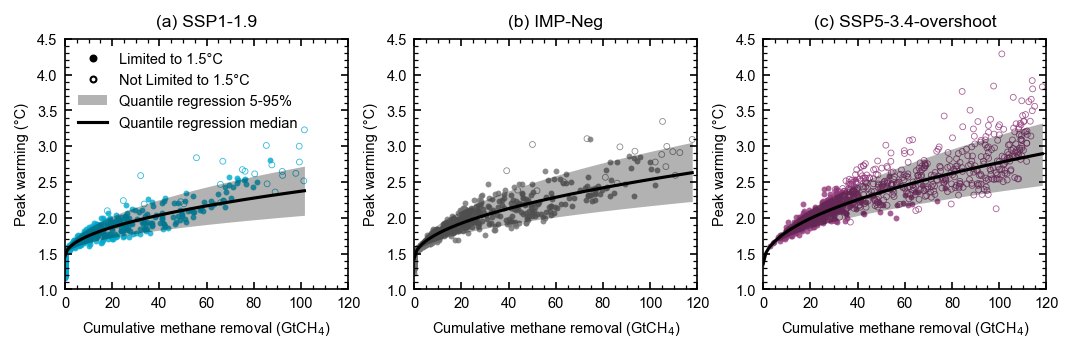

In [27]:
fig, ax = pl.subplots(1, 3, figsize=(18/2.54, 6/2.54))
for iscen, scenario in enumerate(scenarios):
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[~exceeds[scenario]]/1000, 
        np.max(
            noch4r.temperature.loc[
                dict(scenario=scenario, layer=0)
            ] - np.average(
                noch4r.temperature.loc[
                    dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        )[~exceeds[scenario]],
        label=labels[scenario],
        s=8,
        lw=0,
        alpha=0.8,
        color=colors[scenario],
        marker="o"
    )
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[exceeds[scenario]]/1000, 
        np.max(
            noch4r.temperature.loc[
                dict(scenario=scenario, layer=0)
            ] - np.average(
                noch4r.temperature.loc[
                    dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        )[exceeds[scenario]],
        label=labels[scenario],
        s=8,
        lw=0.4,
        alpha=0.8,
        edgecolor=colors[scenario],
        color="None",
        marker="o"
    )
    
    q = {}
    for qm, res in zip(quantiles, res_allsr[scenario]):
        q[qm] = res.predict({'ch4': x_psr[scenario]})
        # get prediction for the model and plot
        # here we use a dict which works the same way as the df in ols
    ax[iscen].fill_between(x_psr[scenario], q[.05], q[.95], color='k', alpha=0.3, lw=0)
    ax[iscen].plot(x_psr[scenario], q[.5], color='k')

    ax[iscen].set_title(f'({chr(97+iscen)}) {labels[scenario]}')
    ax[iscen].set_xlabel('Cumulative methane removal (GtCH$_4$)')
    ax[iscen].set_ylabel('Peak warming (°C)')
    ax[iscen].set_xlim(0, 120)
    ax[iscen].set_ylim(1, 4.5)
    

# Custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color="None", label='Limited to 1.5°C', markerfacecolor='k', markersize=np.sqrt(8)),
    Line2D([0], [0], marker='o', color='None', label='Not Limited to 1.5°C', markerfacecolor='w', markeredgecolor='k', markersize=np.sqrt(8), lw=0.4),
    Patch(facecolor='0.7', lw=0, label='Quantile regression 5-95%'),
    Line2D([0], [0], color='k', lw=1.5, label='Quantile regression median'),
]
ax[0].legend(handles=legend_elements, loc='upper left', frameon=False)

fig.tight_layout()
pl.savefig('../plots/cumCH4_peakT_quantsquarerootfit_cal-1.4.0.png')
pl.savefig('../plots/cumCH4_peakT_quantsquarerootfit_cal-1-4-0.pdf')

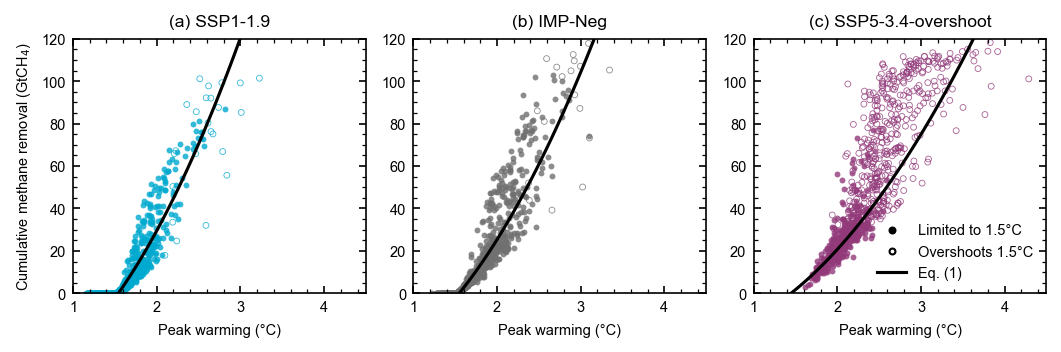

In [28]:
fig, ax = pl.subplots(1, 3, figsize=(18/2.54, 6/2.54))
for iscen, scenario in enumerate(scenarios):
    ax[iscen].scatter(
        np.max(
            noch4r.temperature.loc[
                dict(scenario=scenario, layer=0)
            ] - np.average(
                noch4r.temperature.loc[
                    dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        )[~exceeds[scenario]],
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[~exceeds[scenario]]/1000, 
        label=labels[scenario],
        s=8,
        lw=0,
        alpha=0.8,
        color=colors[scenario],
        marker="o"
    )
    ax[iscen].scatter(
        np.max(
            noch4r.temperature.loc[
                dict(scenario=scenario, layer=0)
            ] - np.average(
                noch4r.temperature.loc[
                    dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))
                ], axis=0, weights=temp_norm_20032022
            ) + 1.03, axis=0
        )[exceeds[scenario]],
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[exceeds[scenario]]/1000, 
        label=labels[scenario],
        s=8,
        lw=0.4,
        alpha=0.8,
        edgecolor=colors[scenario],
        color="None",
        marker="o"
    )
    
    q = {}
    for qm, res in zip(quantiles, res_allsq[scenario]):
        q[qm] = res.predict({'peak': x_psq[scenario]})
        # get prediction for the model and plot
        # here we use a dict which works the same way as the df in ols
#    ax[iscen].fill_between(x_psq[scenario], q[.05], q[.95], color='k', alpha=0.3, lw=0)
    ax[iscen].plot(x_psq[scenario], q[.5], color='k')

#    ax[iscen].plot(np.linspace(1.5, 4.5, 301), squarefit(np.linspace(1.5, 4.5, 301), psq[scenario]), color='k')
    
    ax[iscen].set_title(f'({chr(97+iscen)}) {labels[scenario]}')
    if iscen==0:
        ax[iscen].set_ylabel('Cumulative methane removal (GtCH$_4$)')
    ax[iscen].set_xlabel('Peak warming (°C)')
    ax[iscen].set_ylim(0, 120)
    ax[iscen].set_xlim(1, 4.5)
    

# Custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color="None", label='Limited to 1.5°C', markerfacecolor='k', markersize=np.sqrt(8)),
    Line2D([0], [0], marker='o', color='None', label='Overshoots 1.5°C', markerfacecolor='w', markeredgecolor='k', markersize=np.sqrt(8), lw=0.4),
    # Patch(facecolor='0.7', lw=0, label='Quantile regression 5-95%'),
    Line2D([0], [0], color='k', lw=1.5, label='Eq. (1)'),
]
ax[2].legend(handles=legend_elements, loc='lower right', frameon=False)

fig.tight_layout()
pl.savefig('../plots/peakT_cumCH4_quantsquarefit_cal-1.4.0.png')
pl.savefig('../plots/peakT_cumCH4_quantsquarefit_cal-1-4-0.pdf')

In [29]:
for scenario in scenarios:
    for qidx in [0, 2, 4]:
        print(scenario, quantiles[qidx])
        print(res_allsr[scenario][qidx].params)
        print()

ssp119 0.05
Intercept        1.47677
I(ch4 ** 0.5)    0.05540
dtype: float64

ssp119 0.5
Intercept        1.461695
I(ch4 ** 0.5)    0.090931
dtype: float64

ssp119 0.95
Intercept        1.463262
I(ch4 ** 0.5)    0.124887
dtype: float64

COFFEE1.1 EN_NPi2020_400f_lowBECCS 0.05
Intercept        1.466738
I(ch4 ** 0.5)    0.070185
dtype: float64

COFFEE1.1 EN_NPi2020_400f_lowBECCS 0.5
Intercept        1.427305
I(ch4 ** 0.5)    0.110789
dtype: float64

COFFEE1.1 EN_NPi2020_400f_lowBECCS 0.95
Intercept        1.429994
I(ch4 ** 0.5)    0.149595
dtype: float64

ssp534-over 0.05
Intercept        1.443168
I(ch4 ** 0.5)    0.092841
dtype: float64

ssp534-over 0.5
Intercept        1.357914
I(ch4 ** 0.5)    0.141297
dtype: float64

ssp534-over 0.95
Intercept        1.283385
I(ch4 ** 0.5)    0.187595
dtype: float64



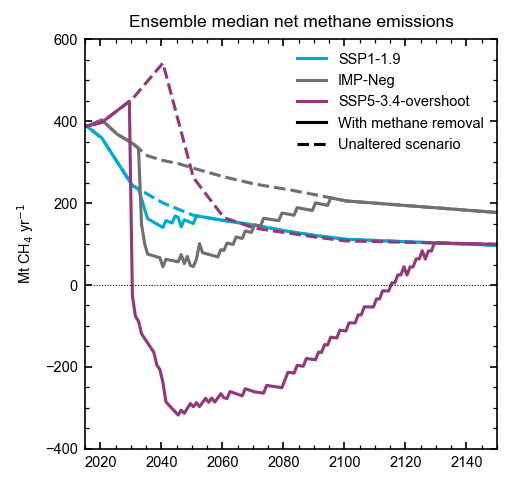

In [30]:
fig, ax = pl.subplots(figsize=(9/2.54, 9/2.54))
for scenario in scenarios:
    ax.plot(
        noch4r.timepoint, 
        np.median(noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')], axis=1), color=colors[scenario],
        ls = '--'
    );
    ax.plot(
        ch4r.timepoint, 
        np.median(ch4r.emissions.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
    
hands, labs = ax.get_legend_handles_labels()

hands.append(Line2D([0], [0], color='k', lw=1.5))
hands.append(Line2D([0], [0], color='k', ls='--', lw=1.5))
labs.append('With methane removal')
labs.append('Unaltered scenario')

ax.set_xlim(2015, 2150)
ax.set_ylim(-400, 600)
ax.axhline(0, lw=0.5, ls=':', color='k')
ax.set_ylabel('Mt CH$_4$ yr$^{-1}$')
ax.legend(hands, labs, frameon=False)
ax.set_title('Ensemble median net methane emissions');
pl.savefig('../plots/netCH4emissions_cal-1.4.0.png')
pl.savefig('../plots/netCH4emissions_cal-1.4.0.pdf')

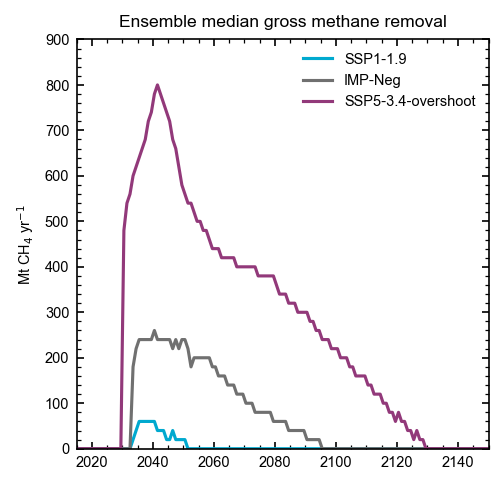

In [31]:
fig, ax = pl.subplots(figsize=(9/2.54, 9/2.54))
for scenario in scenarios:
    ax.plot(
        ch4r.timepoint, 
        np.median(noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')] - ch4r.emissions.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
ax.set_xlim(2015, 2150)
ax.set_ylim(0, 900)
ax.axhline(0, lw=0.5, ls=':', color='k')
ax.set_ylabel('Mt CH$_4$ yr$^{-1}$')
ax.legend(frameon=False)
ax.set_title('Ensemble median gross methane removal');
pl.savefig('../plots/grossCH4removal_cal-1.4.0.png')
pl.savefig('../plots/grossCH4removal_cal-1.4.0.pdf')

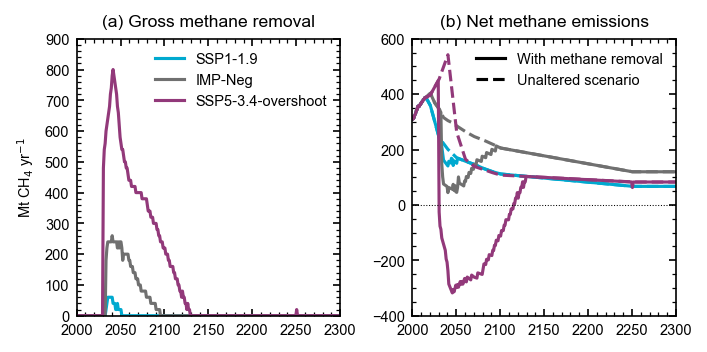

In [32]:
fig, ax = pl.subplots(1, 2, figsize=(12/2.54, 6/2.54))
for scenario in scenarios:
    ax[1].plot(
        noch4r.timepoint, 
        np.median(noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')], axis=1), color=colors[scenario],
        ls='--',
    );
    ax[1].plot(
        ch4r.timepoint, 
        np.median(ch4r.emissions.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
ax[1].set_xlim(2000, 2300)
ax[1].set_ylim(-400, 600)
ax[1].axhline(0, lw=0.5, ls=':', color='k')
#ax[1].set_ylabel('Mt CH$_4$ yr$^{-1}$')
ax[1].set_title('(b) Net methane emissions');

hands = []
labs = []
#hands, labs = ax[1].get_legend_handles_labels()
hands.append(Line2D([0], [0], color='k', lw=1.5))
hands.append(Line2D([0], [0], color='k', ls='--', lw=1.5))
labs.append('With methane removal')
labs.append('Unaltered scenario')
ax[1].legend(hands, labs, frameon=False)

for scenario in scenarios:
    ax[0].plot(
        ch4r.timepoint, 
        np.median(noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')] - ch4r.emissions.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
ax[0].set_xlim(2000, 2300)
ax[0].set_ylim(0, 900)
ax[0].axhline(0, lw=0.5, ls=':', color='k')
ax[0].set_ylabel('Mt CH$_4$ yr$^{-1}$')
ax[0].legend(frameon=False)
ax[0].set_title('(a) Gross methane removal');
fig.tight_layout()

pl.savefig('../plots/netCH4emissions_grossCH4removal_cal-1.4.0.png')
pl.savefig('../plots/netCH4emissions_grossCH4removal_cal-1.4.0.pdf')

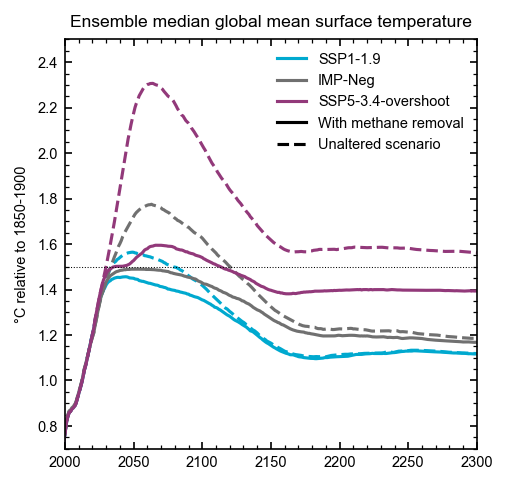

In [33]:
fig, ax = pl.subplots(figsize=(9/2.54, 9/2.54))
for scenario in scenarios:
    ax.plot(
        noch4r.timebound, 
        np.median(
            (
                noch4r.temperature.loc[dict(scenario=scenario, layer=0)] -
                np.average(noch4r.temperature.loc[dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03
            ),
            axis=1
        ), color=colors[scenario],
        ls='--',
    );
    ax.plot(
        ch4r.timebound, 
        np.median(
            (
                ch4r.temperature.loc[dict(scenario=scenario)] -
                np.average(ch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03
            ), axis=1), color=colors[scenario],
        label=labels[scenario]
    );
hands, labs = ax.get_legend_handles_labels()
hands.append(Line2D([0], [0], color='k', lw=1.5))
hands.append(Line2D([0], [0], color='k', ls='--', lw=1.5))
labs.append('With methane removal')
labs.append('Unaltered scenario')
ax.set_xlim(2000, 2300)
ax.set_ylim(0.7, 2.5)
ax.axhline(0, lw=0.5, ls=':', color='k')
ax.set_ylabel('°C relative to 1850-1900')
ax.axhline(1.5, lw=0.5, ls=':', color='k')
ax.legend(hands, labs, frameon=False)
ax.set_title('Ensemble median global mean surface temperature');
pl.savefig('../plots/temperature-cal_1.4.0.png')
pl.savefig('../plots/temperature-cal_1.4.0.pdf')

In [34]:
np.median(
    (
        noch4r.temperature.loc[dict(scenario='ssp119', layer=0)] -
        np.average(noch4r.temperature.loc[dict(scenario='ssp119', layer=0, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
        + 1.03
    ),
    axis=1
).max()

1.5644331031024397

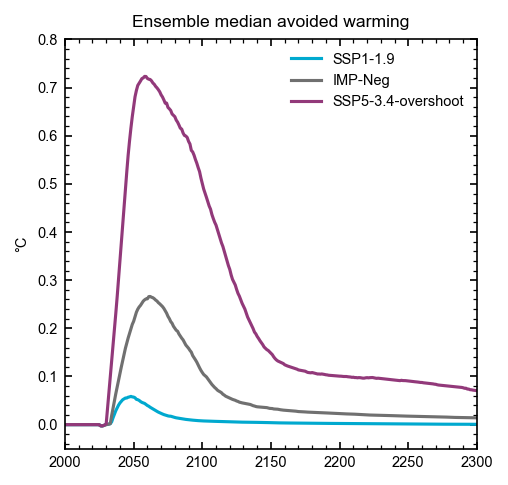

In [35]:
fig, ax = pl.subplots(figsize=(9/2.54, 9/2.54))
for scenario in scenarios:
    ax.plot(
        noch4r.timebound, 
        np.median(
            (
                noch4r.temperature.loc[dict(scenario=scenario, layer=0)] -
                np.average(noch4r.temperature.loc[dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03
            ) - (
                ch4r.temperature.loc[dict(scenario=scenario)] -
                np.average(ch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03
            ),
            axis=1
        ),
        color=colors[scenario],
        label=labels[scenario]
    );

ax.set_xlim(2000, 2300)
ax.set_ylim(-0.05, 0.8)
ax.set_ylabel('°C')
ax.axhline(1.5, lw=0.5, ls=':', color='k')
ax.legend(frameon=False)
ax.set_title('Ensemble median avoided warming');
pl.savefig('../plots/avoidedwarming_cal-1.4.0.png')
pl.savefig('../plots/avoidedwarming_cal-1.4.0.pdf')

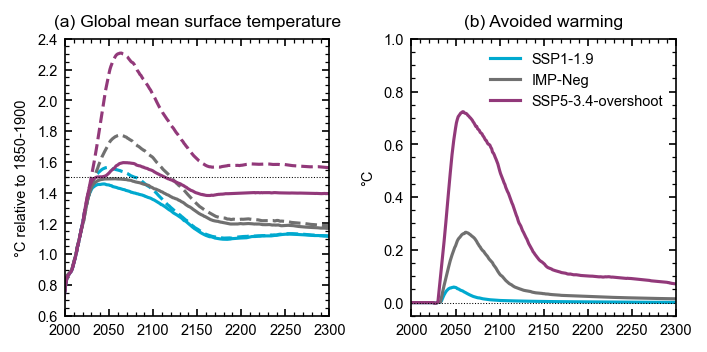

In [36]:
fig, ax = pl.subplots(1, 2, figsize=(12/2.54, 6/2.54))
for scenario in scenarios:
    # ax[0].fill_between(
    #     ch4r.timebound, 
    #     np.percentile(ch4r.temperature.loc[dict(scenario=scenario)] -
    #             np.average(ch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
    #             + 1.03, 5, axis=1), 
    #     np.percentile(ch4r.temperature.loc[dict(scenario=scenario)] -
    #             np.average(ch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
    #             + 1.03, 95, axis=1), 
    #     color=colors[scenario],
    #     lw=0.5,
    #     alpha=0.2,
    # );
    ax[0].plot(
        noch4r.timebound, 
        np.median(
            (
                noch4r.temperature.loc[dict(scenario=scenario, layer=0)] -
                np.average(noch4r.temperature.loc[dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03
            ),
            axis=1
        ),
        color=colors[scenario],
        ls='--',
    );
    ax[0].plot(
        ch4r.timebound, 
        np.median(ch4r.temperature.loc[dict(scenario=scenario)] -
                np.average(ch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03, axis=1), color=colors[scenario],
        label=labels[scenario]
    );
hands, labs = ax[0].get_legend_handles_labels()
# hands.append(Line2D([0], [0], color='k', lw=1.5))
# hands.append(Line2D([0], [0], color='k', ls='--', lw=1.5))
# labs.append('With methane removal')
# labs.append('Unaltered scenario')
ax[0].set_xlim(2000, 2300)
ax[0].set_ylim(0.6, 2.4)
ax[0].axhline(0, lw=0.5, ls=':', color='k')
ax[0].set_ylabel('°C relative to 1850-1900')
ax[0].axhline(1.5, lw=0.5, ls=':', color='k')
# ax[0].legend(hands, labs, frameon=False)
ax[0].set_title('(a) Global mean surface temperature');

for scenario in scenarios:
    # ax[1].fill_between(
    #     ch4r.timebound, 
    #     np.percentile(
    #         (
    #             noch4r.temperature.loc[dict(scenario=scenario, layer=0)] -
    #             np.average(noch4r.temperature.loc[dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
    #             + 1.03
    #         ) - (
    #             ch4r.temperature.loc[dict(scenario=scenario)] -
    #             np.average(ch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
    #             + 1.03
    #         ),
    #         5,
    #         axis=1
    #     ),
    #     np.percentile(
    #         (
    #             noch4r.temperature.loc[dict(scenario=scenario, layer=0)] -
    #             np.average(noch4r.temperature.loc[dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
    #             + 1.03
    #         ) - (
    #             ch4r.temperature.loc[dict(scenario=scenario)] -
    #             np.average(ch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
    #             + 1.03
    #         ),
    #         95,
    #         axis=1
    #     ),
    #     color=colors[scenario],
    #     lw=0.5,
    #     alpha=0.2,
    # );
    ax[1].plot(
        noch4r.timebound, 
        np.median(
            (
                noch4r.temperature.loc[dict(scenario=scenario, layer=0)] -
                np.average(noch4r.temperature.loc[dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03
            ) - (
                ch4r.temperature.loc[dict(scenario=scenario)] -
                np.average(ch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03
            ),
            axis=1
        ),
        color=colors[scenario],
        label=labels[scenario]
    );

ax[1].set_xlim(2000, 2300)
ax[1].set_ylim(-0.05, 1.0)
ax[1].set_ylabel('°C')
ax[1].axhline(0, lw=0.5, ls=':', color='k')
ax[1].legend(frameon=False)
ax[1].set_title('(b) Avoided warming');

fig.tight_layout()
pl.savefig('../plots/temperature-cal_1.4.0.png')
pl.savefig('../plots/temperature-cal_1.4.0.pdf')

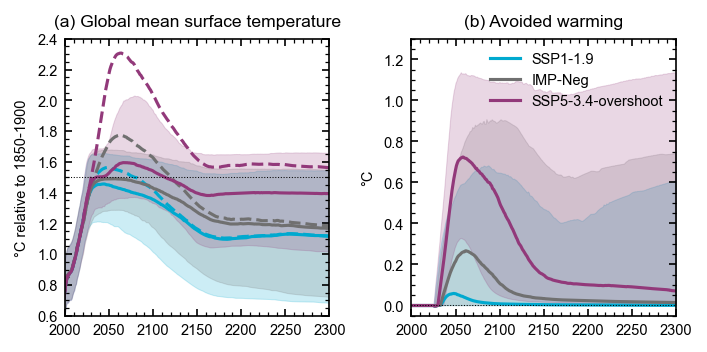

In [37]:
fig, ax = pl.subplots(1, 2, figsize=(12/2.54, 6/2.54))
for scenario in scenarios:
    ax[0].fill_between(
        ch4r.timebound, 
        np.percentile(ch4r.temperature.loc[dict(scenario=scenario)] -
                np.average(ch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03, 5, axis=1), 
        np.percentile(ch4r.temperature.loc[dict(scenario=scenario)] -
                np.average(ch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03, 95, axis=1), 
        color=colors[scenario],
        lw=0.5,
        alpha=0.2,
    );
    ax[0].plot(
        noch4r.timebound, 
        np.median(
            (
                noch4r.temperature.loc[dict(scenario=scenario, layer=0)] -
                np.average(noch4r.temperature.loc[dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03
            ),
            axis=1
        ),
        color=colors[scenario],
        ls='--',
    );
    ax[0].plot(
        ch4r.timebound, 
        np.median(ch4r.temperature.loc[dict(scenario=scenario)] -
                np.average(ch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03, axis=1), color=colors[scenario],
        label=labels[scenario]
    );
hands, labs = ax[0].get_legend_handles_labels()
# hands.append(Line2D([0], [0], color='k', lw=1.5))
# hands.append(Line2D([0], [0], color='k', ls='--', lw=1.5))
# labs.append('With methane removal')
# labs.append('Unaltered scenario')
ax[0].set_xlim(2000, 2300)
ax[0].set_ylim(0.6, 2.4)
ax[0].axhline(0, lw=0.5, ls=':', color='k')
ax[0].set_ylabel('°C relative to 1850-1900')
ax[0].axhline(1.5, lw=0.5, ls=':', color='k')
# ax[0].legend(hands, labs, frameon=False)
ax[0].set_title('(a) Global mean surface temperature');

for scenario in scenarios:
    ax[1].fill_between(
        ch4r.timebound, 
        np.percentile(
            (
                noch4r.temperature.loc[dict(scenario=scenario, layer=0)] -
                np.average(noch4r.temperature.loc[dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03
            ) - (
                ch4r.temperature.loc[dict(scenario=scenario)] -
                np.average(ch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03
            ),
            5,
            axis=1
        ),
        np.percentile(
            (
                noch4r.temperature.loc[dict(scenario=scenario, layer=0)] -
                np.average(noch4r.temperature.loc[dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03
            ) - (
                ch4r.temperature.loc[dict(scenario=scenario)] -
                np.average(ch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03
            ),
            95,
            axis=1
        ),
        color=colors[scenario],
        lw=0.5,
        alpha=0.2,
    );
    ax[1].plot(
        noch4r.timebound, 
        np.median(
            (
                noch4r.temperature.loc[dict(scenario=scenario, layer=0)] -
                np.average(noch4r.temperature.loc[dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03
            ) - (
                ch4r.temperature.loc[dict(scenario=scenario)] -
                np.average(ch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
                + 1.03
            ),
            axis=1
        ),
        color=colors[scenario],
        label=labels[scenario]
    );

ax[1].set_xlim(2000, 2300)
ax[1].set_ylim(-0.05, 1.3)
ax[1].set_ylabel('°C')
ax[1].axhline(0, lw=0.5, ls=':', color='k')
ax[1].legend(frameon=False)
ax[1].set_title('(b) Avoided warming');

fig.tight_layout()
pl.savefig('../plots/temperature-uncert-cal_1.4.0.png')
pl.savefig('../plots/temperature-uncert-cal_1.4.0.pdf')

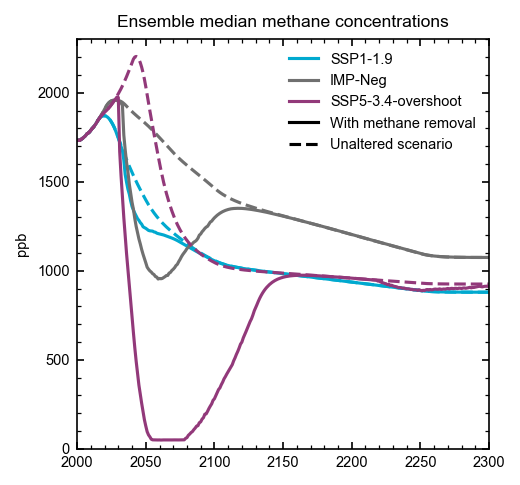

In [38]:
fig, ax = pl.subplots(figsize=(9/2.54, 9/2.54))
for scenario in scenarios:
    ax.plot(
        noch4r.timebound, 
        np.median(noch4r.concentration.loc[dict(scenario=scenario, specie='CH4')], axis=1), color=colors[scenario],
        ls='--'
    );
    ax.plot(
        ch4r.timebound, 
        np.median(ch4r.concentration.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
hands, labs = ax.get_legend_handles_labels()
hands.append(Line2D([0], [0], color='k', lw=1.5))
hands.append(Line2D([0], [0], color='k', ls='--', lw=1.5))
labs.append('With methane removal')
labs.append('Unaltered scenario')
ax.set_xlim(2000, 2300)
ax.set_ylim(0, 2300)
ax.set_ylabel('ppb')
ax.legend(hands, labs, frameon=False)
ax.set_title('Ensemble median methane concentrations');
pl.savefig('../plots/CH4concentrations_cal-1.4.0.png')
pl.savefig('../plots/CH4concentrations_cal-1.4.0.pdf')

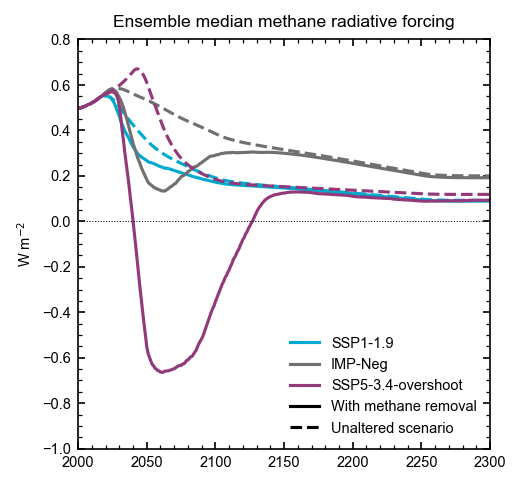

In [39]:
fig, ax = pl.subplots(figsize=(9/2.54, 9/2.54))
for scenario in scenarios:
    ax.plot(
        noch4r.timebound, 
        np.median(noch4r.forcing.loc[dict(scenario=scenario, specie='CH4')], axis=1), color=colors[scenario],
        ls='--',
    );
    ax.plot(
        ch4r.timebound, 
        np.median(ch4r.forcing_ch4.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
hands, labs = ax.get_legend_handles_labels()
hands.append(Line2D([0], [0], color='k', lw=1.5))
hands.append(Line2D([0], [0], color='k', ls='--', lw=1.5))
labs.append('With methane removal')
labs.append('Unaltered scenario')
ax.set_xlim(2000, 2300)
ax.set_xlim(2000, 2300)
ax.set_ylim(-1, 0.8)
ax.axhline(0, lw=0.5, ls=':', color='k')
ax.set_ylabel('W m$^{-2}$')
ax.legend(hands, labs, frameon=False)
ax.set_title('Ensemble median methane radiative forcing');
pl.savefig('../plots/CH4forcing_cal-1.4.0.png')
pl.savefig('../plots/CH4forcing_cal-1.4.0.pdf')

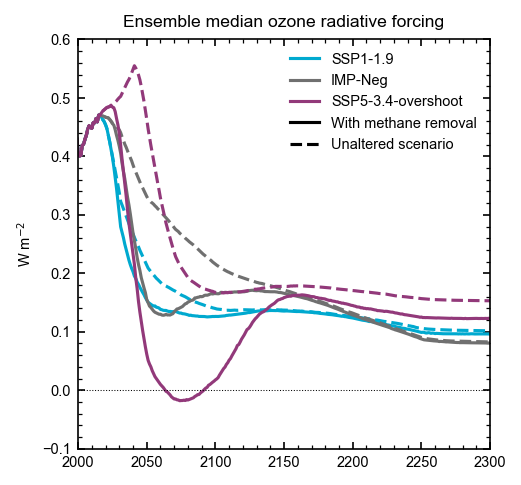

In [40]:
fig, ax = pl.subplots(figsize=(9/2.54, 9/2.54))
for scenario in scenarios:
    ax.plot(
        noch4r.timebound, 
        np.median(noch4r.forcing.loc[dict(scenario=scenario, specie='Ozone')], axis=1), color=colors[scenario],
        ls='--',
    );
    ax.plot(
        ch4r.timebound, 
        np.median(ch4r.forcing_o3.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
hands, labs = ax.get_legend_handles_labels()
hands.append(Line2D([0], [0], color='k', lw=1.5))
hands.append(Line2D([0], [0], color='k', ls='--', lw=1.5))
labs.append('With methane removal')
labs.append('Unaltered scenario')
ax.set_xlim(2000, 2300)
ax.set_ylim(-0.1, 0.6)
ax.set_ylabel('W m$^{-2}$')
ax.axhline(0, lw=0.5, ls=':', color='k')
ax.legend(hands, labs, frameon=False)
ax.set_title('Ensemble median ozone radiative forcing');
pl.savefig('../plots/O3forcing_cal-1.4.0.png')
pl.savefig('../plots/O3forcing_cal-1.4.0.pdf')

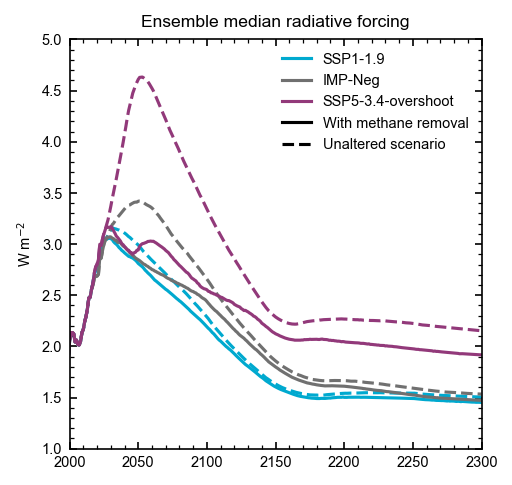

In [41]:
fig, ax = pl.subplots(figsize=(9/2.54, 9/2.54))
for scenario in scenarios:
    ax.plot(
        noch4r.timebound, 
        np.median(noch4r.forcing_sum.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        ls = '--',
    );
    ax.plot(
        ch4r.timebound, 
        np.median(ch4r.forcing_sum.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
hands, labs = ax.get_legend_handles_labels()
hands.append(Line2D([0], [0], color='k', lw=1.5))
hands.append(Line2D([0], [0], color='k', ls='--', lw=1.5))
labs.append('With methane removal')
labs.append('Unaltered scenario')
ax.set_xlim(2000, 2300)
ax.set_ylim(1, 5)
ax.set_ylabel('W m$^{-2}$')
ax.axhline(0, lw=0.5, ls=':', color='k')
ax.legend(hands, labs, frameon=False)
ax.set_title('Ensemble median radiative forcing');
pl.savefig('../plots/totalforcing_cal-1.4.0.png')
pl.savefig('../plots/totalforcing_cal-1.4.0.pdf')

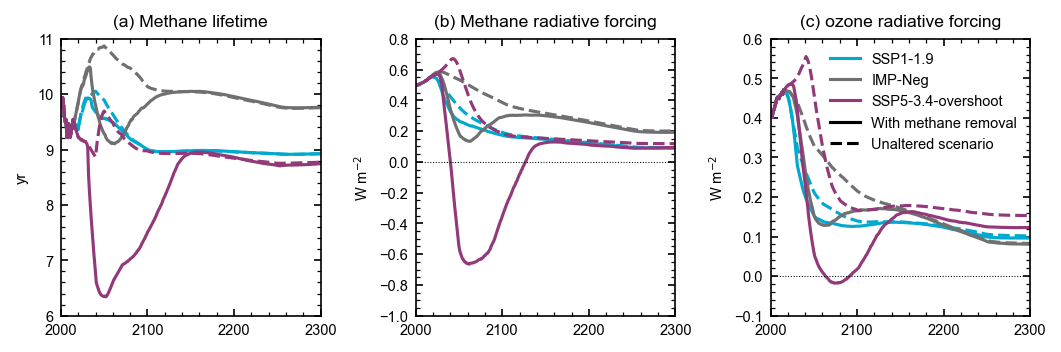

In [42]:
fig, ax = pl.subplots(1,3,figsize=(18/2.54, 6/2.54))
for scenario in scenarios:
    ax[0].plot(
        noch4r.timebound, 
        np.median(noch4r_lifetime.loc[dict(scenario=scenario)].__xarray_dataarray_variable__, axis=1), color=colors[scenario],
        ls = '--'
    );
    ax[0].plot(
        ch4r.timebound, 
        np.median(ch4r.lifetime.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
hands, labs = ax[0].get_legend_handles_labels()
hands.append(Line2D([0], [0], color='k', lw=1.5))
hands.append(Line2D([0], [0], color='k', ls='--', lw=1.5))
labs.append('With methane removal')
labs.append('Unaltered scenario')
ax[0].set_xlim(2000, 2300)
ax[0].set_ylim(6, 11)
ax[0].set_ylabel('yr')
ax[0].axhline(0, lw=0.5, ls=':', color='k')
#ax[0].legend(hands, labs, frameon=False)
ax[0].set_title('(a) Methane lifetime');

for scenario in scenarios:
    ax[1].plot(
        noch4r.timebound, 
        np.median(noch4r.forcing.loc[dict(scenario=scenario, specie='CH4')], axis=1), color=colors[scenario],
        ls='--',
    );
    ax[1].plot(
        ch4r.timebound, 
        np.median(ch4r.forcing_ch4.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
#hands, labs = ax.get_legend_handles_labels()
hands.append(Line2D([0], [0], color='k', lw=1.5))
hands.append(Line2D([0], [0], color='k', ls='--', lw=1.5))
labs.append('With methane removal')
labs.append('Unaltered scenario')
ax[1].set_xlim(2000, 2300)
ax[1].set_xlim(2000, 2300)
ax[1].set_ylim(-1, 0.8)
ax[1].axhline(0, lw=0.5, ls=':', color='k')
ax[1].set_ylabel('W m$^{-2}$')
ax[1].set_title('(b) Methane radiative forcing');

for scenario in scenarios:
    ax[2].plot(
        noch4r.timebound, 
        np.median(noch4r.forcing.loc[dict(scenario=scenario, specie='Ozone')], axis=1), color=colors[scenario],
        ls='--',
    );
    ax[2].plot(
        ch4r.timebound, 
        np.median(ch4r.forcing_o3.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
hands, labs = ax[1].get_legend_handles_labels()
hands.append(Line2D([0], [0], color='k', lw=1.5))
hands.append(Line2D([0], [0], color='k', ls='--', lw=1.5))
labs.append('With methane removal')
labs.append('Unaltered scenario')
ax[2].set_xlim(2000, 2300)
ax[2].set_ylim(-0.1, 0.6)
ax[2].set_ylabel('W m$^{-2}$')
ax[2].axhline(0, lw=0.5, ls=':', color='k')
ax[2].legend(hands, labs, frameon=False)
ax[2].set_title('(c) ozone radiative forcing');

fig.tight_layout()
pl.savefig('../plots/CH4lifetime-O3forcing_cal-1.4.0.png')
pl.savefig('../plots/CH4lifetime-O3forcing_cal-1.4.0.pdf')

In [43]:
noch4r_lifetime.loc[dict(scenario=scenario)]

<xarray.Dataset>
Dimensions:                        (config: 841, timebounds: 551)
Coordinates:
  * config                         (config) int32 2463 2658 ... 1595963 1597740
  * timebounds                     (timebounds) float64 1.75e+03 ... 2.3e+03
    scenario                       <U11 'ssp534-over'
    specie                         object ...
Data variables:
    __xarray_dataarray_variable__  (timebounds, config) float64 ...

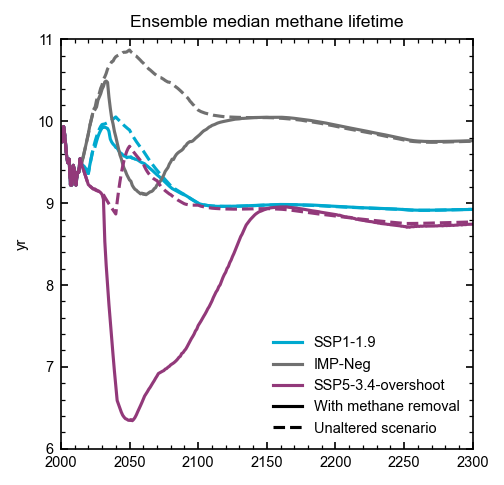

In [44]:
fig, ax = pl.subplots(figsize=(9/2.54, 9/2.54))
for scenario in scenarios:
    ax.plot(
        noch4r.timebound, 
        np.median(noch4r_lifetime.loc[dict(scenario=scenario)].__xarray_dataarray_variable__, axis=1), color=colors[scenario],
        ls = '--'
    );
    ax.plot(
        ch4r.timebound, 
        np.median(ch4r.lifetime.loc[dict(scenario=scenario)], axis=1), color=colors[scenario],
        label=labels[scenario]
    );
hands, labs = ax.get_legend_handles_labels()
hands.append(Line2D([0], [0], color='k', lw=1.5))
hands.append(Line2D([0], [0], color='k', ls='--', lw=1.5))
labs.append('With methane removal')
labs.append('Unaltered scenario')
ax.set_xlim(2000, 2300)
ax.set_ylim(6, 11)
ax.set_ylabel('yr')
ax.axhline(0, lw=0.5, ls=':', color='k')
ax.legend(hands, labs, frameon=False)
ax.set_title('Ensemble median methane lifetime');
pl.savefig('../plots/CH4lifetime_cal-1.4.0.png')
pl.savefig('../plots/CH4lifetime_cal-1.4.0.pdf')

In [45]:
noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')].shape

(550, 841)

In [46]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

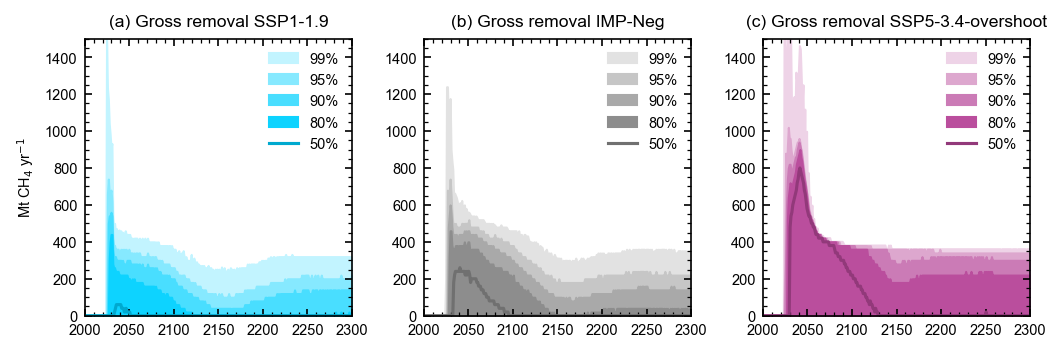

In [47]:
fig, ax = pl.subplots(1, 3, figsize=(18/2.54, 6/2.54))
for iscen, scenario in enumerate(scenarios):

    ax[iscen].fill_between(
        ch4r.timepoint, 
        np.percentile(
            (
                noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')] -
                ch4r.emissions.loc[dict(scenario=scenario)]
            ),
            99,
            axis=1
        ),
        color=lighten_color(colors[scenario], 0.2),
        label='99%',
    );
    
    ax[iscen].fill_between(
        ch4r.timepoint, 
        np.percentile(
            (
                noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')] -
                ch4r.emissions.loc[dict(scenario=scenario)]
            ),
            95,
            axis=1
        ),
        color=lighten_color(colors[scenario], 0.4),
        label='95%',
    );
    
    ax[iscen].fill_between(
        ch4r.timepoint, 
        np.percentile(
            (
                noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')] -
                ch4r.emissions.loc[dict(scenario=scenario)]
            ),
            90,
            axis=1
        ),
        color=lighten_color(colors[scenario], 0.6),
        label='90%',
    );
    
    ax[iscen].fill_between(
        ch4r.timepoint, 
        np.percentile(
            (
                noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')] -
                ch4r.emissions.loc[dict(scenario=scenario)]
            ),
            80,
            axis=1
        ),
        color=lighten_color(colors[scenario], 0.8),
        label='80%',
    );
    
    ax[iscen].plot(
        ch4r.timepoint, 
        np.median(noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')] - ch4r.emissions.loc[dict(scenario=scenario)], axis=1), 
        color=colors[scenario],
        label='50%',
    );
    ax[iscen].set_xlim(2000, 2300)
    ax[iscen].set_ylim(0,1500)
    #ax.set_ylim(0, 900)
    if iscen==0:
        ax[iscen].set_ylabel('Mt CH$_4$ yr$^{-1}$')
    ax[iscen].legend(frameon=False)
    ax[iscen].set_title(f'({chr(iscen+97)}) Gross removal {labels[scenario]}');
fig.tight_layout()
pl.savefig('../plots/grossCH4removalpercentiles_cal-1.4.0.png')
pl.savefig('../plots/grossCH4removalpercentiles_cal-1.4.0.pdf')

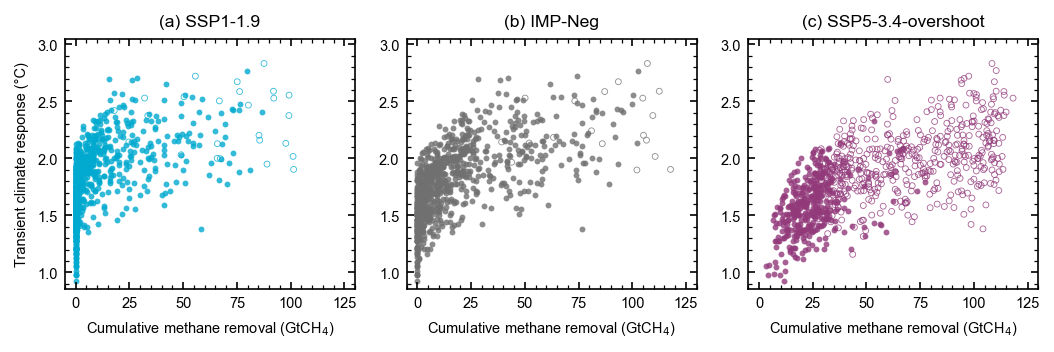

In [48]:
fig, ax = pl.subplots(1, 3, figsize=(18/2.54, 6/2.54))
for iscen, scenario in enumerate(scenarios):
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[exceeds[scenario]]/1000, 
        ecs_tcr["TCR"][exceeds[scenario]],
        label=labels[scenario],
        s=8,
        lw=0.4,
        alpha=0.8,
        edgecolor=colors[scenario],
        color="None",
        marker="o"
    )
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[~exceeds[scenario]]/1000, 
        ecs_tcr["TCR"][~exceeds[scenario]],
        label=labels[scenario],
        s=8,
        lw=0,
        alpha=0.8,
        color=colors[scenario],
        marker="o"
    )
    ax[iscen].set_title(f'({chr(iscen+97)}) {labels[scenario]}')
    ax[iscen].set_xlabel('Cumulative methane removal (GtCH$_4$)')
    if iscen==0:
        ax[iscen].set_ylabel('Transient climate response (°C)')
    ax[iscen].set_xlim(-5, 130)
    ax[iscen].set_ylim(0.85, 3.05)
fig.tight_layout()
pl.savefig('../plots/cumCH4_TCR_cal-1.4.0.png')
pl.savefig('../plots/cumCH4_TCR_cal-1.4.0.pdf')

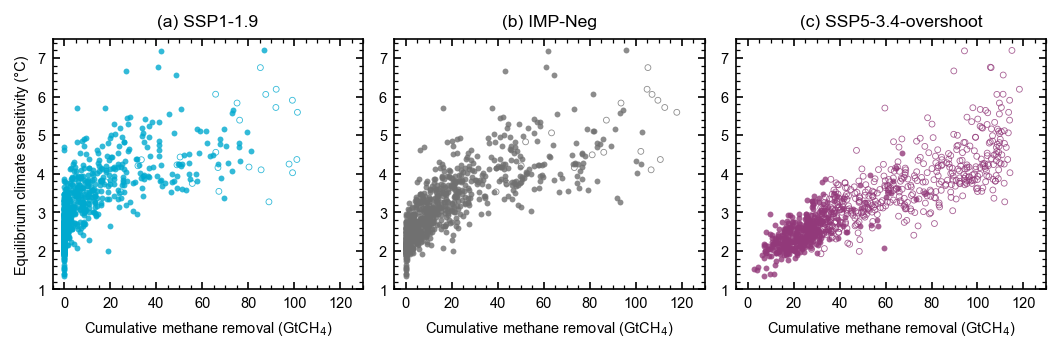

In [49]:
fig, ax = pl.subplots(1, 3, figsize=(18/2.54, 6/2.54))
for iscen, scenario in enumerate(scenarios):
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[exceeds[scenario]]/1000, 
        ecs_tcr["ECS"][exceeds[scenario]],
        label=labels[scenario],
        s=8,
        lw=0.4,
        alpha=0.8,
        edgecolor=colors[scenario],
        color="None",
        marker="o"
    )
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[~exceeds[scenario]]/1000, 
        ecs_tcr["ECS"][~exceeds[scenario]],
        label=labels[scenario],
        s=8,
        lw=0,
        alpha=0.8,
        color=colors[scenario],
        marker="o"
    )
    ax[iscen].set_title(f'({chr(iscen+97)}) {labels[scenario]}')
    ax[iscen].set_xlabel('Cumulative methane removal (GtCH$_4$)')
    if iscen==0:
        ax[iscen].set_ylabel('Equilibrium climate sensitivity (°C)')
    ax[iscen].set_xlim(-5, 130)
    ax[iscen].set_ylim(1, 7.5)
fig.tight_layout()
pl.savefig('../plots/cumCH4_ECS_cal-1.4.0.png')
pl.savefig('../plots/cumCH4_ECS_cal-1.4.0.pdf')

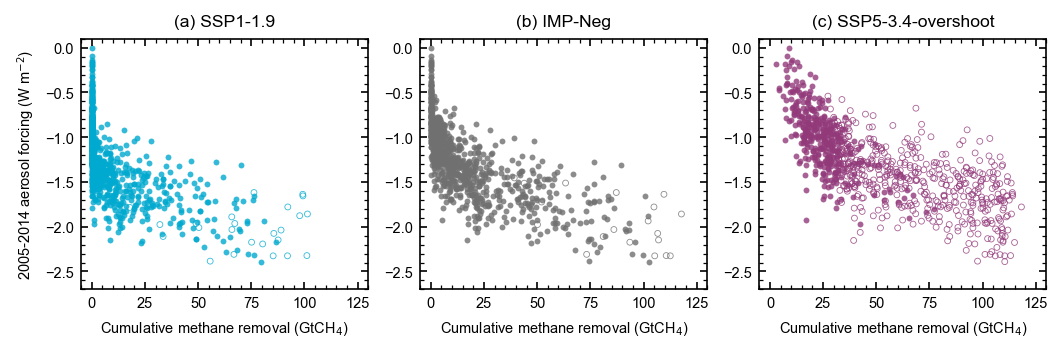

In [50]:
fig, ax = pl.subplots(1, 3, figsize=(18/2.54, 6/2.54))
for iscen, scenario in enumerate(scenarios):
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[exceeds[scenario]]/1000, 
        (
            noch4r.forcing.loc[
                dict(scenario=scenario, specie='Aerosol-radiation interactions', timebound=np.arange(2005, 2015))
            ].mean(dim='timebound')+noch4r.forcing.loc[
                dict(scenario=scenario, specie='Aerosol-cloud interactions', timebound=np.arange(2005, 2015))
            ].mean(dim='timebound')
        )[exceeds[scenario]],
        label=labels[scenario],
        s=8,
        lw=0.4,
        alpha=0.8,
        edgecolor=colors[scenario],
        color="None",
        marker="o"
    )
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[~exceeds[scenario]]/1000, 
        (
            noch4r.forcing.loc[
                dict(scenario=scenario, specie='Aerosol-radiation interactions', timebound=np.arange(2005, 2015))
            ].mean(dim='timebound')+noch4r.forcing.loc[
                dict(scenario=scenario, specie='Aerosol-cloud interactions', timebound=np.arange(2005, 2015))
            ].mean(dim='timebound')
        )[~exceeds[scenario]],
        label=labels[scenario],
        s=8,
        lw=0,
        alpha=0.8,
        color=colors[scenario],
        marker="o"
    )
    ax[iscen].set_title(f'({chr(iscen+97)}) {labels[scenario]}')
    ax[iscen].set_xlabel('Cumulative methane removal (GtCH$_4$)')
    if iscen==0:
        ax[iscen].set_ylabel('2005-2014 aerosol forcing (W m$^{-2}$)')
    ax[iscen].set_xlim(-5, 130)
    ax[iscen].set_ylim(-2.7, 0.1)
fig.tight_layout()
pl.savefig('../plots/cumCH4_aerosolF_cal-1.4.0.png')
pl.savefig('../plots/cumCH4_aerosolF_cal-1.4.0.pdf')

In [51]:
zec = pd.read_csv('../results/zec_esm-bell_cal-1.4.0.csv', index_col=0)
zec

,zec48_750,zec50_750,zec100_750,zec50_1000,zec100_1000
2463,-0.042462,-0.043241,-0.057933,-0.041864,-0.044468
2658,-0.106631,-0.109444,-0.163463,-0.130781,-0.189115
4204,0.037790,0.039536,0.071359,0.062879,0.119807
4743,0.150475,0.155750,0.251933,0.220175,0.365883
6941,-0.009972,-0.010375,-0.018711,-0.000224,0.004527
...,...,...,...,...,...
1592375,-0.019894,-0.020306,-0.034419,-0.023858,-0.041198
1593438,-0.062323,-0.063811,-0.088098,-0.070090,-0.089426
1595003,0.135432,0.139819,0.216308,0.201225,0.319432
1595963,-0.028999,-0.029288,-0.036583,-0.032506,-0.034498


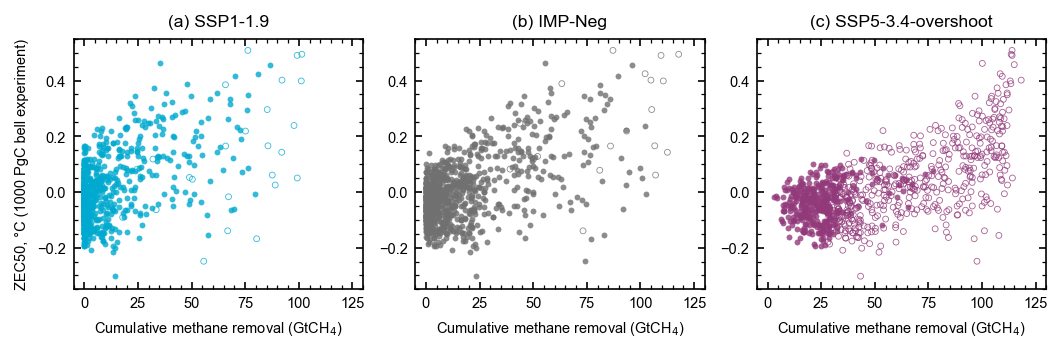

In [52]:
fig, ax = pl.subplots(1, 3, figsize=(18/2.54, 6/2.54))
for iscen, scenario in enumerate(scenarios):
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[exceeds[scenario]]/1000, 
        zec.zec50_1000[exceeds[scenario]],
        label=labels[scenario],
        s=8,
        lw=0.4,
        alpha=0.8,
        edgecolor=colors[scenario],
        color="None",
        marker="o"
    )
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[~exceeds[scenario]]/1000, 
        zec.zec50_1000[~exceeds[scenario]],
        label=labels[scenario],
        s=8,
        lw=0,
        alpha=0.8,
        color=colors[scenario],
        marker="o"
    )
    ax[iscen].set_xlabel('Cumulative methane removal (GtCH$_4$)')
    if iscen==0:
        ax[iscen].set_ylabel('ZEC50, °C (1000 PgC bell experiment)')
    ax[iscen].set_xlim(-5, 130)
    ax[iscen].set_ylim(-0.35, 0.55)
    ax[iscen].set_title(f'({chr(iscen+97)}) {labels[scenario]}')   
fig.tight_layout()
pl.savefig('../plots/cumCH4_zec50_1000_cal-1.4.0.png')
pl.savefig('../plots/cumCH4_zec50_1000_cal-1.4.0.pdf')

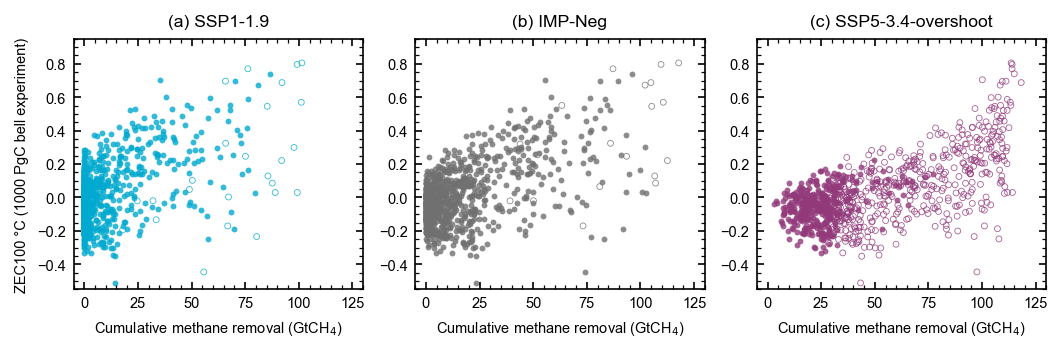

In [53]:
fig, ax = pl.subplots(1, 3, figsize=(18/2.54, 6/2.54))
for iscen, scenario in enumerate(scenarios):
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[exceeds[scenario]]/1000, 
        zec.zec100_1000[exceeds[scenario]],
        label=labels[scenario],
        s=8,
        lw=0.4,
        alpha=0.8,
        edgecolor=colors[scenario],
        color="None",
        marker="o"
    )
    ax[iscen].scatter(
        -np.sum(
            ch4r.emissions.loc[
                dict(scenario=scenario)
            ] - noch4r.emissions.loc[
                dict(scenario=scenario, specie='CH4')
            ], axis=0
        )[~exceeds[scenario]]/1000, 
        zec.zec100_1000[~exceeds[scenario]],
        label=labels[scenario],
        s=8,
        lw=0,
        alpha=0.8,
        color=colors[scenario],
        marker="o"
    )
    ax[iscen].set_xlabel('Cumulative methane removal (GtCH$_4$)')
    if iscen==0:
        ax[iscen].set_ylabel('ZEC100 °C (1000 PgC bell experiment)')
    ax[iscen].set_xlim(-5, 130)
    ax[iscen].set_ylim(-0.55, 0.95)
    ax[iscen].set_title(f'({chr(iscen+97)}) {labels[scenario]}')
fig.tight_layout()
pl.savefig('../plots/cumCH4_zec100_1000_cal-1.4.0.png')
pl.savefig('../plots/cumCH4_zec100_1000_cal-1.4.0.pdf')

In [54]:
ch4_obs = pd.read_csv('../data/constraints/IGCC_methane_concentrations_1750-2022.csv', index_col=0)
gmst_obs = pd.read_csv('../data/constraints/IGCC_GMST_1850-2022.csv', index_col=0)

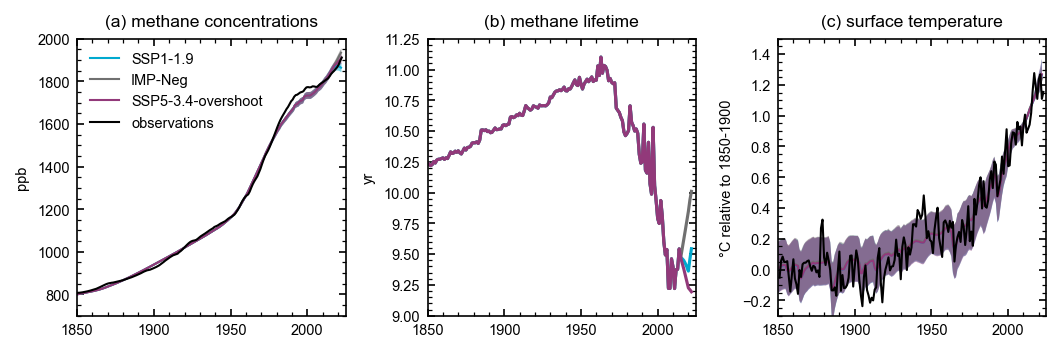

In [55]:
fig, ax = pl.subplots(1, 3, figsize=(18/2.54, 6/2.54))
for scenario in scenarios:
    ax[0].fill_between(
        np.arange(1750, 2023), 
        ch4r.concentration.sel(scenario=scenario, timebound=np.arange(1750, 2023)).min(dim='config'),
        ch4r.concentration.sel(scenario=scenario, timebound=np.arange(1750, 2023)).max(dim='config'),
        color=colors[scenario],
        alpha=0.5,
        lw=0
    );
    ax[0].plot(
        np.arange(1750, 2023), 
        ch4r.concentration.sel(scenario=scenario, timebound=np.arange(1750, 2023)).median(dim='config'),
        color=colors[scenario],
        lw=1,
        label=f'{labels[scenario]}',
    );
ax[0].plot(ch4_obs.index+0.5, ch4_obs, color='k', lw=1, label='observations')
ax[0].legend(frameon=False)
ax[0].set_xlim(1850, 2025);
ax[0].set_ylim(700, 2000);
ax[0].set_ylabel('ppb')
ax[0].set_title('(a) methane concentrations')

for scenario in scenarios:
    ax[1].plot(
        np.arange(1750, 2023), 
        ch4r.lifetime.sel(scenario=scenario, timebound=np.arange(1750, 2023)).median(dim='config'), color=colors[scenario],
    );
ax[1].set_xlim(1850, 2025);
ax[1].set_ylim(9, 11.25);
ax[1].set_ylabel('yr')
ax[1].set_title('(b) methane lifetime')

for scenario in scenarios:
    ax[2].fill_between(
        np.arange(1750, 2023), 
        (
            ch4r.temperature.sel(scenario=scenario, timebound=np.arange(1750, 2023))
          - np.average(noch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024), layer=0)], weights=temp_norm_20032022, axis=0)
          + 1.03
        ).quantile(0.05, dim='config'),
        (
            ch4r.temperature.sel(scenario=scenario, timebound=np.arange(1750, 2023))
          - np.average(noch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024), layer=0)], weights=temp_norm_20032022, axis=0)
          + 1.03
        ).quantile(0.95, dim='config'),
        color=colors[scenario],
        alpha=0.5,
        lw=0
    );
    ax[2].plot(
        np.arange(1750, 2023), 
        (
            noch4r.temperature.sel(scenario=scenario, timebound=np.arange(1750, 2023), layer=0) -
            np.average(noch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024), layer=0)], weights=temp_norm_20032022, axis=0)
            + 1.03
        ).median(dim='config'),
        color=colors[scenario],
        lw=1,
        label=f'FaIR {labels[scenario]}',
    );
ax[2].plot(gmst_obs.index+0.5, gmst_obs, color='k', lw=1)
ax[2].set_xlim(1850, 2025);
ax[2].set_ylim(-0.3, 1.5);
ax[2].set_ylabel('°C relative to 1850-1900')
ax[2].set_title('(c) surface temperature')

fig.tight_layout()
pl.savefig('../plots/historical_cal-1.4.0.png')
pl.savefig('../plots/historical_cal-1.4.0.pdf')

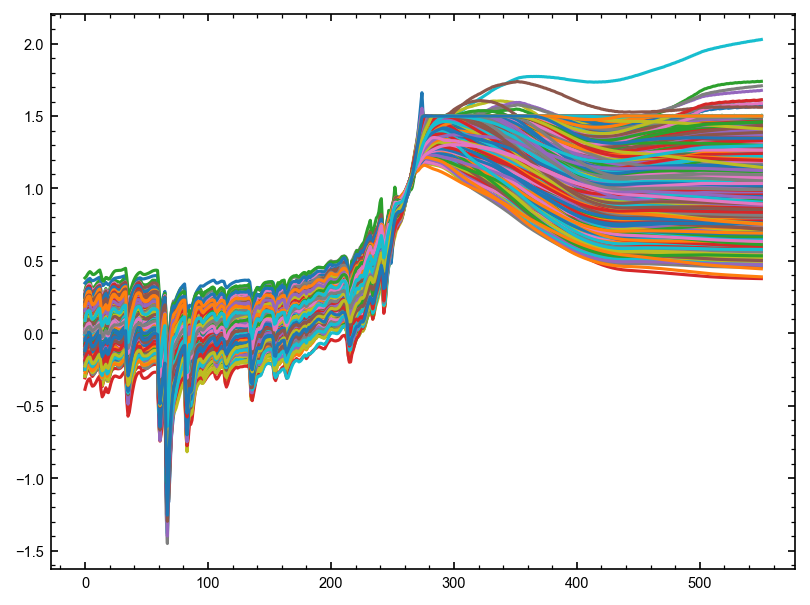

In [56]:
pl.plot(1.03 + ch4r.temperature[:, 0, :] - np.average(ch4r.temperature[253:274, 0, :].data, weights=temp_norm_20032022, axis=0));

In [57]:
np.average(ch4r.temperature[253:274, 0, :].data, weights=temp_norm_20032022, axis=0)#.mean(axis=0)

array([1.01765624, 1.03963203, 1.18994346, 1.05336556, 1.14421504,
       1.2344523 , 1.1534098 , 0.81712785, 0.9808931 , 0.93435574,
       0.82635582, 1.07993795, 1.0755218 , 1.03575535, 1.04086028,
       0.9018568 , 0.92799982, 0.96353648, 0.97010962, 1.08335293,
       0.92831134, 1.09670817, 1.1764996 , 1.33707799, 0.89974477,
       1.00600948, 1.14410409, 0.83801145, 0.92271031, 1.14581967,
       1.07125434, 1.25501237, 1.12027985, 1.07308317, 1.07361557,
       1.15309891, 0.96732549, 1.16007232, 1.03727154, 1.13031198,
       1.13908519, 1.0553477 , 1.11465861, 1.01658458, 0.96025916,
       1.05423478, 1.19074864, 0.84405349, 0.91564036, 0.99853344,
       0.99503431, 0.96870505, 1.19696225, 1.24445031, 1.06986437,
       0.92954525, 1.16808558, 0.755953  , 1.17520925, 1.08417245,
       1.06746739, 0.98896146, 1.11324628, 1.01832412, 1.09287629,
       1.00647837, 1.07905248, 0.97884465, 0.95923304, 0.75944412,
       1.22640058, 1.07804013, 1.13882359, 0.92833854, 1.01765

In [58]:
np.average(noch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024), layer=0)], weights=temp_norm_20032022, axis=0)

array([1.00758043, 1.03836744, 1.19276936, 1.05015885, 1.1454826 ,
       1.2334303 , 1.16034238, 0.81841285, 0.98230341, 0.93897844,
       0.81623263, 1.06714468, 1.06703145, 1.0396489 , 1.04621227,
       0.90734776, 0.93032389, 0.96574904, 0.97080216, 1.08714248,
       0.93001056, 1.10010443, 1.18001535, 1.34143967, 0.90152025,
       1.01154079, 1.14917136, 0.83103554, 0.91373161, 1.14950735,
       1.07429173, 1.26163151, 1.12558642, 1.08100446, 1.07529099,
       1.16160322, 0.97014541, 1.16065521, 1.03800326, 1.12796398,
       1.14478568, 1.05944399, 1.1095965 , 1.01999235, 0.96255859,
       1.05677425, 1.19625405, 0.84736031, 0.91708609, 1.000155  ,
       1.00019919, 0.97288374, 1.20011634, 1.24490011, 1.06828781,
       0.91886293, 1.17182236, 0.75276407, 1.17949193, 1.08929333,
       1.07112235, 0.99258058, 1.10869892, 1.01973721, 1.09150306,
       1.01144438, 1.08054147, 0.97989303, 0.95626522, 0.75976581,
       1.2289538 , 1.07172805, 1.14460296, 0.93115921, 1.02125

## Calculate effective cumulative removal

[Abernethy et al. 2021](https://royalsocietypublishing.org/doi/10.1098/rsta.2021.0104)

$E(t) = \int_0^t R(t') e^{-t'/\tau} dt'$

In [59]:
scenario='ssp119'

In [60]:
# R(t')
noch4r.emissions.loc[dict(scenario=scenario, specie='CH4')] - ch4r.emissions.loc[dict(scenario=scenario)]

<xarray.DataArray 'emissions' (timepoint: 550, config: 841)>
array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [220.,   0.,   0., ...,   0.,   0.,   0.],
       [180.,   0.,   0., ...,   0.,   0.,   0.],
       [220.,   0.,   0., ...,   0.,   0.,   0.]])
Coordinates:
  * config     (config) int32 2463 2658 4204 4743 ... 1595003 1595963 1597740
  * timepoint  (timepoint) float64 1.75e+03 1.752e+03 ... 2.298e+03 2.3e+03
    specie     <U3 'CH4'
    scenario   <U6 'ssp119'

In [61]:
# tau
ch4r.lifetime.loc[dict(scenario=scenario)]

<xarray.DataArray 'lifetime' (timebound: 551, config: 841)>
[463391 values with dtype=float64]
Coordinates:
  * config     (config) int32 2463 2658 4204 4743 ... 1595003 1595963 1597740
  * timebound  (timebound) int32 1750 1751 1752 1753 ... 2297 2298 2299 2300
    scenario   <U6 'ssp119'

In [62]:
# first R(t') where we see any action. This is 2024 to 2025, so could be the cumulative R at 2025.01.01
noch4r.emissions.loc[dict(scenario=scenario, specie='CH4', timepoint=2024.5)] - ch4r.emissions.loc[dict(scenario=scenario, timepoint=2024.5)]

<xarray.DataArray 'emissions' (config: 841)>
array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0., 1260.,    0.,
          0.,    0.,  640.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0., 1400.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,  700.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,  200.,  480.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,  160.,    0.,    0.,    0.,    0.,  740.,    0.,
          0.,    0.,    0., 1320.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,  440.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0., 1760.,    0.,
...
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0., 1040.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0., 2980.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   20.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,  800.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,  280.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0., 1180.])
Coordinates:
  * config     (config) int32 2463 2658 4204 4743 ... 1595003 1595963 1597740
    timepoint  float64 2.024e+03
    specie     <U3 'CH4'
    scenario   <U6 'ssp119'

In [63]:
ch4r.lifetime.loc[dict(scenario=scenario, timebound=2025)]

<xarray.DataArray 'lifetime' (config: 841)>
[841 values with dtype=float64]
Coordinates:
  * config     (config) int32 2463 2658 4204 4743 ... 1595003 1595963 1597740
    timebound  int32 2025
    scenario   <U6 'ssp119'

In [64]:
# first R(t') where we see any action. This is 2024 to 2025, so could be the cumulative R at 2025.01.01
(
    noch4r.emissions.loc[dict(scenario=scenario, specie='CH4', timepoint=2024.5)] - 
    ch4r.emissions.loc[dict(scenario=scenario, timepoint=2024.5)]
) / np.exp(-1 / ch4r.lifetime.loc[dict(scenario=scenario, timebound=2025)])

<xarray.DataArray (config: 841)>
array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
       1397.07557224,    0.        ,    0.        ,    0.        ,
        709.46811741,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
       1553.7194546 ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,  777.5062701 ,    0.        ,    0.        ,
...
         22.20688151,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
        888.01407738,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,  310.81817364,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
       1309.94392213])
Coordinates:
  * config     (config) int32 2463 2658 4204 4743 ... 1595003 1595963 1597740
    timepoint  float64 2.024e+03
    specie     <U3 'CH4'
    scenario   <U6 'ssp119'
    timebound  int32 2025

In [65]:
# do a numerical integration
equivalent_marginal_removal = np.zeros((278, 841))
for itb, timebound in enumerate(range(2023, 2301)):
    equivalent_marginal_removal[itb, :] = (
        noch4r.emissions.loc[dict(scenario=scenario, specie='CH4', timepoint=timebound-0.5)] - 
        ch4r.emissions.loc[dict(scenario=scenario, timepoint=timebound-0.5)]
    ) / np.exp(-1 / ch4r.lifetime.loc[dict(scenario=scenario, timebound=timebound)])

In [66]:
equivalent_cumulative_removal = np.nancumsum(equivalent_marginal_removal, axis=0)

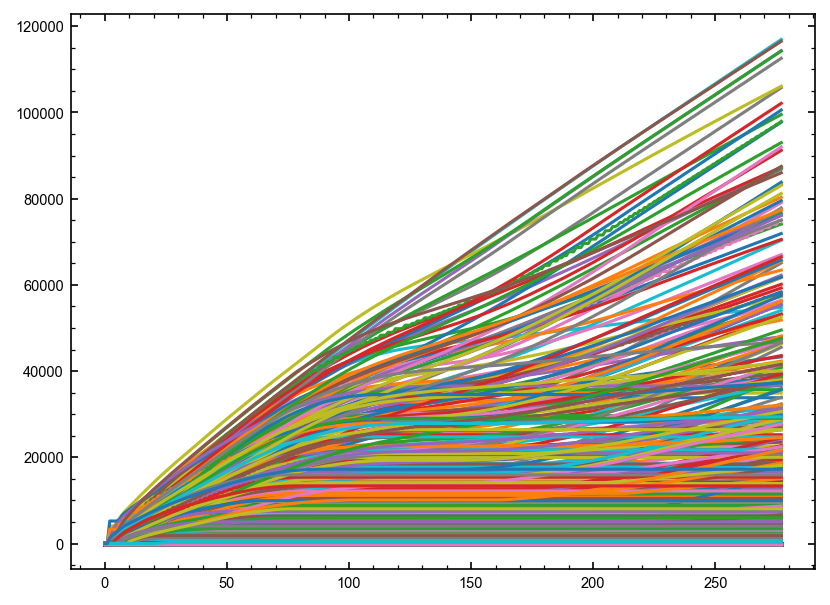

In [67]:
pl.plot(equivalent_cumulative_removal);

In [68]:
delta_T = (
    noch4r.temperature.loc[dict(scenario=scenario, layer=0)] -
    np.average(noch4r.temperature.loc[dict(scenario=scenario, layer=0, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
    + 1.03
) - (
    ch4r.temperature.loc[dict(scenario=scenario)] -
    np.average(ch4r.temperature.loc[dict(scenario=scenario, timebound=np.arange(2003,2024))], weights=temp_norm_20032022, axis=0).mean()
    + 1.03
)[273:, :]

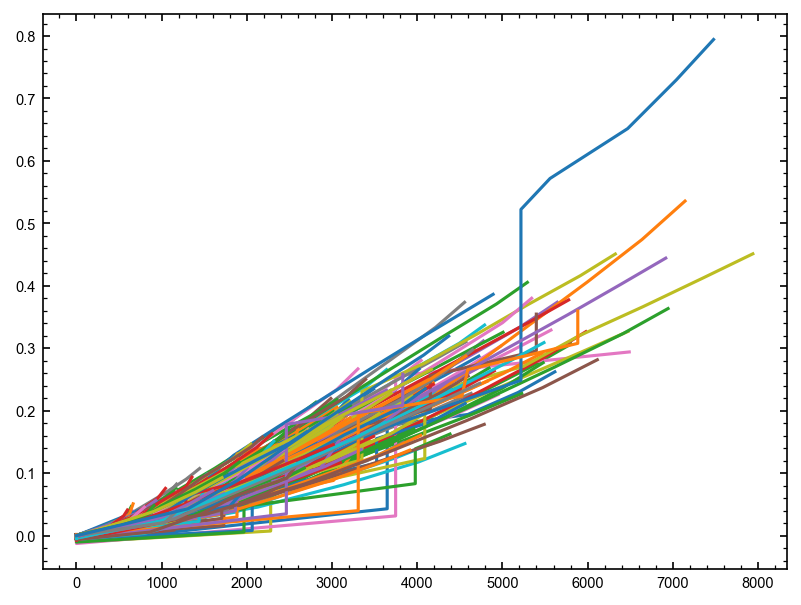

In [69]:
pl.plot(equivalent_cumulative_removal[:10, :], delta_T[:10, :]);